## NumPy filters (no ML!)

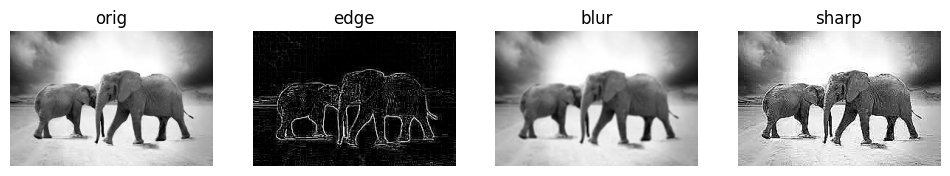

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def to_gray(img):
    if img.mode != "L":
        img = img.convert("L")
    return np.array(img, dtype=np.float32)

def conv2d_gray(img, kernel):
    H, W = img.shape
    k = kernel.shape[0]
    pad = k // 2
    padded = np.pad(img, pad, mode="edge")
    out = np.zeros_like(img)
    for y in range(H):
        for x in range(W):
            patch = padded[y:y+k, x:x+k]
            out[y, x] = (patch * kernel).sum()
    # clamp to displayable range
    out = np.clip(out, 0, 255)
    return out

img = Image.open("images.jpg")  # or use a small included sample
g = to_gray(img)

edge = np.array([[ -1,-1,-1],
                    [ -1, 8,-1],
                    [ -1,-1,-1]], dtype=np.float32)

blur = (1/9.0) * np.ones((3,3), dtype=np.float32)

sharp = np.array([[ 0,-1,0],
                    [ -1, 5,-1],
                    [ 0,-1, 0]], dtype=np.float32)

g_edge = conv2d_gray(g, edge)
g_blur = conv2d_gray(g, blur)
g_sharp = conv2d_gray(g, sharp)

fig, axs = plt.subplots(1,4, figsize=(12,3))
for ax, arr, title in zip(axs, [g, g_edge, g_blur, g_sharp], ["orig", "edge", "blur", "sharp"]):
    ax.imshow(arr, cmap="gray"); ax.set_title(title); ax.axis("off")
plt.show()


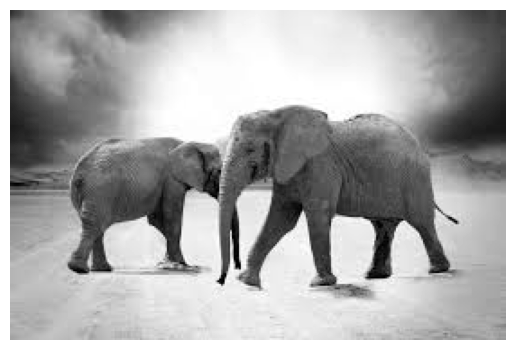

In [9]:
def to_gray(img):
    if img.mode != "L":
        img = img.convert("L")
    return np.array(img, dtype=np.float32)

img = Image.open("images.jpg")
g = to_gray(img)

plt.imshow(g, cmap='gray')
plt.axis('off')  # Hide the axes for a cleaner display
plt.show()

## Match NumPy conv to nn.Conv2d

In [3]:
import torch
import torch.nn as nn
import numpy as np

# Make a single-channel 1x1 image with a simple pattern
x = torch.zeros(1, 1, 6, 6)
x[:, :, 2:4, 2:4] = 1.0  # a bright square in the center

# A hand-crafted edge kernel (same as Lesson 0)
k = torch.tensor([[-1,-1,-1],
                    [-1, 8,-1],
                    [-1,-1,-1]], dtype=torch.float32)  # shape (outC,inC,kh,kw)

# Use Conv2d with fixed weights, no bias, padding=1 to keep size
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
with torch.no_grad():
    conv.weight.copy_(k)

y = conv(x)
print("Input shape:", x.shape)   # (1,1,6,6)
print("Input map:\n", x[0,0])
print("Output shape:", y.shape)  # (1,1,6,6)
print("Output map:\n", y[0,0])


Input shape: torch.Size([1, 1, 6, 6])
Input map:
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
Output shape: torch.Size([1, 1, 6, 6])
Output map:
 tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1., -2., -2., -1.,  0.],
        [ 0., -2.,  5.,  5., -2.,  0.],
        [ 0., -2.,  5.,  5., -2.,  0.],
        [ 0., -1., -2., -2., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]], grad_fn=<SelectBackward0>)


In [2]:
relu = nn.ReLU()
pool = nn.MaxPool2d(2)

yr = relu(y)
yp = pool(yr)
print("ReLU(y):\n", yr[0,0])
print("Pooled:\n", yp[0,0])

ReLU(y):
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 5., 5., 0., 0.],
        [0., 0., 5., 5., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], grad_fn=<SelectBackward0>)
Pooled:
 tensor([[0., 0., 0.],
        [0., 5., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)


## ReLU & Pooling

In [4]:
import torch
import torch.nn as nn

x = torch.linspace(-2, 2, steps=16).view(1,1,4,4)  # toy feature map
relu = nn.ReLU()
pool = nn.MaxPool2d(2)  # halves H and W

xr = relu(x)
xp = pool(xr)
print("x:\n", x[0,0])
print("ReLU(x):\n", xr[0,0])
print("Pooled:\n", xp[0,0])


x:
 tensor([[-2.0000, -1.7333, -1.4667, -1.2000],
        [-0.9333, -0.6667, -0.4000, -0.1333],
        [ 0.1333,  0.4000,  0.6667,  0.9333],
        [ 1.2000,  1.4667,  1.7333,  2.0000]])
ReLU(x):
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.1333, 0.4000, 0.6667, 0.9333],
        [1.2000, 1.4667, 1.7333, 2.0000]])
Pooled:
 tensor([[0.0000, 0.0000],
        [1.4667, 2.0000]])


## Tiny CNN

### BarsDataset

**Vertical bar example:**

0001000100010001

0001000100010001

0001000100010001

0001000100010001

**Horizontal bar example:**

0000000000000000

1111111111111111

0000000000000000

1111111111111111

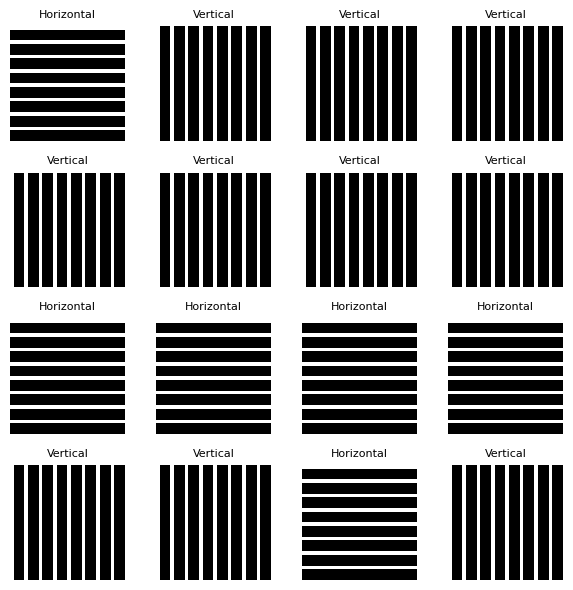

In [9]:
# visualize_bars_dataset.py
import numpy as np
import matplotlib.pyplot as plt

def make_bars_image(size=32, orientation="vertical", spacing=4):
    """
    Create a simple 32x32 image with bars.
    orientation: "vertical" or "horizontal"
    spacing: pixel spacing between bars
    """
    img = np.zeros((size, size), dtype=np.float32)
    if orientation == "vertical":
        img[:, ::spacing] = 1.0   # stripes along columns
    else:
        img[::spacing, :] = 1.0   # stripes along rows
    return img

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for ax in axes.ravel():
    if np.random.rand() < 0.5:
        img = make_bars_image(32, "vertical")
        label = "Vertical"
    else:
        img = make_bars_image(32, "horizontal")
        label = "Horizontal"
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title(label, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

class BarsDataset(Dataset):
    def __init__(self, n=1000, size=32):
        self.x = []
        self.y = []
        for _ in range(n):
            img = np.zeros((size, size), np.float32)
            if np.random.rand() < 0.5:
                # vertical bars
                img[:, ::4] = 1.0; label = 0
            else:
                # horizontal bars
                img[::4, :] = 1.0; label = 1
            self.x.append(img)
            self.y.append(label)
        self.x = torch.tensor(np.stack(self.x))[:, None, :, :]  # (N,1,H,W)
        self.y = torch.tensor(self.y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]

class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*8*8, 2)
        )
    def forward(self, x): return self.net(x)
    
ds = BarsDataset(n=2000, size=32)
dl = DataLoader(ds, batch_size=64, shuffle=True)

model = TinyCNN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    total, correct, running = 0, 0, 0.0
    for xb, yb in dl:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        running += float(loss)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item(); total += yb.size(0)
    print(f"epoch {epoch+1} loss {running/len(dl):.3f} acc {correct/total:.3f}")


epoch 1 loss 0.307 acc 0.904
epoch 2 loss 0.002 acc 1.000
epoch 3 loss 0.000 acc 1.000
epoch 4 loss 0.000 acc 1.000
epoch 5 loss 0.000 acc 1.000


In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional feature extractor
        self.conv = nn.Sequential(
            # nn.Conv2d(in_channels, out_channels, kernel_size, padding=)
            nn.Conv2d(1, 16, 3, padding=1),  # 1x28x28 -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 16x28x28 -> 16x14x14
            nn.Conv2d(16, 32, 3, padding=1), # 16x14x14 -> 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 32x14x14 -> 32x7x7
        )
        # Fully‐connected classifier 
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128), # flatten 32x7x7 -> 1568 -> 128
            nn.ReLU(),
            nn.Linear(128, 10)          # 128 -> 10 output logits (digits 0–9)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) # flatten batch of feature maps to vectors
        x = self.fc(x)
        return x

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor()  # scales pixel values to [0.0, 1.0]
])
train_set = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# NEW: test loader for final accuracy
test_set = datasets.MNIST(root='.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)

# Instantiate model, loss function, and optimizer
model = DigitCNN()
criterion = nn.CrossEntropyLoss() # combines LogSoftmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(3): # train for 3 epochs
    print(f"Epoch {epoch + 1}")
    model.train()
    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in loop:
        preds = model(images) # forward pass
        loss = criterion(preds, labels) # compute loss

        optimizer.zero_grad() # reset gradients
        loss.backward() # backpropagate
        optimizer.step() # update weights

        # Update progress bar with current loss value
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} done")

# NEW: Final accuracy on the test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images)
        predicted = preds.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100.0 * correct / total
print(f"Final test accuracy: {accuracy:.2f}%")


Epoch 1


Epoch 1 done
Epoch 2


Epoch 2 done
Epoch 3


Epoch 3 done
Final test accuracy: 98.79%
